In [32]:
# matplotlib
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms

# misc
import time
from datetime import datetime
from torchinfo import summary

# preprocessing 
import av
import pandas as pd
import matplotlib.pyplot as plt
import cv2


# helper classes and functions
from train_model import train
from model import CNN_LSTM, VGG_LSTM

# logging
import os
import logging
from torch.utils.tensorboard import SummaryWriter

In [33]:
try:
    import mediapipe as mp
except:
    !pip install mediapipe
    import mediapipe as mp

In [34]:
# create relevant directories

# create dir to save logs if it does not exist
if not os.path.exists("log"):
    os.mkdir("log")

# create dir to save runs if it does not exist
if not os.path.exists("runs"):
    os.mkdir("runs")

# create dir to save models if it does not exist
if not os.path.exists("saved_models"):
    os.mkdir("saved_models")

In [35]:
log_path = "log/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
sum_path = "runs/cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())

# Log to file & tensorboard writer
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_path), logging.StreamHandler()])
logger = logging.getLogger('signo-lingo')
logger.info('Logging to file...')
writer = SummaryWriter(sum_path)

Logging to file...


In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [37]:
data_dir = "dataset"
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
test_dir = f'{data_dir}/test'


In [38]:
root_path = "dataset"

train_path = [os.path.join('{}/train'.format(root_path), f) for f in os.listdir('{}/train'.format(root_path))]
val_path = [os.path.join('{}/val'.format(root_path), f) for f in os.listdir('{}/val'.format(root_path))]
test_path = [os.path.join('{}/test'.format(root_path), f) for f in os.listdir('{}/test'.format(root_path))]

In [39]:
# All labels
train_label_df = pd.read_csv(r'{}/train_labels.csv'.format(root_path), header=None)
test_label_df = pd.read_csv(r'{}/test_labels.csv'.format(root_path), header=None)
val_label_df = pd.read_csv(r'{}/val_labels.csv'.format(root_path), header=None)

# convert all into hashmap - key = u_vid_name , value = label

train_label = {k[0]: k[1] for k in train_label_df.values.tolist()}
test_label = {k[0]: k[1] for k in test_label_df.values.tolist()}
val_label = {k[0]: k[1] for k in val_label_df.values.tolist()}

In [40]:
# Total label + turkish to english translation

total_label = pd.read_csv(r'{}/ClassId.csv'.format(root_path))
u_len_label = len(total_label['ClassId'].unique())
print("total unique label:", u_len_label)

total unique label: 226


In [41]:
def pose_styling(inp_arr):
    # Set up drawing and holistic
    mp_drawing = mp.solutions.drawing_utils
    mp_holistic = mp.solutions.holistic

    mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=2)

    # Drawing image
    pose_arr = []
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for image in inp_arr:
            results = holistic.process(image)

            # 1. Draw face landmarks
            mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                                     mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                     mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                     )

            # 2. Right hand
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=1),
                                     mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)
                                     )

            # 3. Left Hand
            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1),
                                     mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                                     )

            # 4. Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                                     )

            pose_arr.append(image)
    return pose_arr

In [42]:
# pick fix frames
'''
e.g.
input_frame = 5, output_frame = 3

steps 1. create an array and multiply each frame by output factor
    [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5] 
    
step 2. Divide by output section
    [1, 1, 1, 2, 2, | 2, 3, 3, 3, 4, | 4, 4, 5, 5, 5]
    
step 3. Find the center index to pick
    5 // 2 = 2
    
step 4. Select center index from each section
    [1, 1*, 1, 2, 2, | 2, 3*, 3, 3, 4, | 4, 4*, 5, 5, 5]
    
step 5. Return a set of those index
    set([1, 3, 4])
'''
def fix_frame(input_frame: int, output_frame: int) -> set:
    '''
    input
        - number of input frames
        - number of output frames
    output
        - a set of frames
    '''
    if input_frame < output_frame:
        print('Spotted video that have input frame: {} < output frame: {}'.format(input_frame, output_frame))
        return set([i for i in range(1, input_frame+1)])
    
    # create array to pick from
    pick_arr = []
    for i in range(1,input_frame+1):
        for r in range(output_frame):
            pick_arr.append(i)
            
    # decide on index to capture
    # e.g. frame 58//2 = 29
    ind = input_frame//2
    
    # capture frame
    output = set()
    i = 1
    batch = 0
    while (i + (batch * input_frame)) < len(pick_arr):
        if i == ind:
            output.add(pick_arr[i + (batch * input_frame) - 1])
        i+=1
        if i == input_frame + 1:
            i = 1
            batch += 1
    if len(output) != output_frame:
        raise ValueError('output does not have the same frame requirements. output: {}, required: {}'.format(len(output), output_frame))
    return output

In [43]:
def extract_frames(vid, transforms = None, frames_cap = 30):
    
    selector = fix_frame(len(vid), frames_cap)
    output = []
    for e,frame in enumerate(vid):
        if e+1 in selector:
            output.append(frame)
    
    # edge case
    if len(vid) < frames_cap:
        remainder = frames_cap - len(vid)
        # take last frame
        last_frame = vid[-1]
        for _ in range(remainder):
            output.append(last_frame)
        
    return np.array(output)

In [44]:
# mask rbg image
def masking(rbg_vid, depth_vid):
    """
    input
        - path for rbg
        - path for depth
    output
        - array of numpy arrays
    """
    rbg_arr = []
    container_rbg = av.open(rbg_vid)

    for packet in container_rbg.demux():
        for frame in packet.decode():
            rbg_arr.append(np.array(frame.to_image()))

    depth_arr = []
    container_depth = av.open(depth_vid)

    for packet in container_depth.demux():
        for frame in packet.decode():
            depth_arr.append(np.array(frame.to_image()))
            
    # pose estimation
    rbg_arr = pose_styling(rbg_arr)

    # display - correct color orientation
    overlay_arr = []
    for i in range(len(rbg_arr)):
        c = cv2.cvtColor(rbg_arr[i], cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(depth_arr[i], cv2.COLOR_BGR2GRAY)
        overlay = cv2.bitwise_and(c,c, mask= gray)
        
        # resize and reshape
        overlay = cv2.resize(overlay, (256,256))
        
        # convert from (h , w, c) to (c, h, w)
        overlay_reshape = np.transpose(overlay, (2, 0, 1))
        
        overlay_arr.append(overlay_reshape)
        
    return np.array(overlay_arr)

In [56]:
class Turkish_Dataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self._get_unique()
        
    def _get_unique(self):
        u_vid_depth = {}
        u_vid_color = {}
        u_vid = set()
        for path in self.paths:
            vid = path.split("\\")[-1].split(".")[0] # train\\signer0_sample1_color.mp4 or train\\signer0_sample1_depth.mp4
            vid_split = vid.split("_")
            vid_type = vid_split[-1] # color or depth
            vid_name = "_".join(vid_split[:-1]) # signer0_sample1_color
            if vid_type == "color":
                u_vid_color[vid_name] = path
            elif vid_type == "depth":
                u_vid_depth[vid_name] = path
            else:
                raise ValueError('Detected vid type as neither color nor depth. type is', vid_type)
            u_vid.add(vid_name)
        self.u_vid_depth = u_vid_depth
        self.u_vid_color = u_vid_color
        self.u_vid = list(u_vid)
    
    def __getitem__(self, index):
        vid_name = self.u_vid[index]
        vid_label = self.labels[vid_name]
        
        vid_color = self.u_vid_color[vid_name]
        vid_depth = self.u_vid_depth[vid_name]
        
        # preprocessing
        #vid_arr = masking(vid_color, vid_depth)
#         if (len(vid_arr) < 30):
#             print('{} has {} frames'.format(vid_name, len(vid_arr)))
        vid_arr = extract_frames(vid_arr, 30)

        # create one-hot-encoding for label
        #label = np.zeros(u_len_label)
        label = np.zeros(226)
        label[vid_label] = 1
        
        # convert arr to tensors
        vid_arr = torch.from_numpy(vid_arr).float()
        label = torch.from_numpy(label).long().argmax()
        
        # return masked video array and label
        return vid_arr, label
                
    
    def __len__(self):
        return len(self.u_vid)

In [57]:
n_frames = 30
transforms_compose = transforms.Compose([transforms.Resize(256), 
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5], std=[0.5])])

In [58]:
# create train dataset
ld_train = Turkish_Dataset(train_path, train_label)

# show image but clip rbg values
train_img = np.array(np.transpose(ld_train[0][0][0], (1,2,0))).astype('uint8')
train_img = cv2.cvtColor(train_img, cv2.COLOR_RGB2BGR)               
plt.imshow(train_img)
plt.show()

UnboundLocalError: local variable 'vid_arr' referenced before assignment

In [48]:
# # UNCOMMENT TO SEE SAMPLED FRAMES
# nrows, ncols = 6, 5
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
# for i in range(n_frames):
#     row_idx = i // ncols
#     col_idx = i % ncols
#     ax[row_idx][col_idx].imshow(ld_train[0][0][i].numpy().transpose(1, 2, 0))

# # # UNCOMMENT TO SAVE PLOT
# # plt.savefig('train_30_0.png')

# plt.show()

shape of first array torch.Size([30, 3, 256, 256])


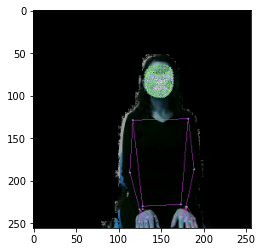

In [49]:
# create test dataset
ld_test = Turkish_Dataset(test_path, test_label)
print("shape of first array", ld_test[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_test[0][0][0].numpy()
img_np_arr -= img_np_arr.min() 
img_np_arr /= img_np_arr.max()
plt.imshow(img_np_arr.transpose(1, 2, 0))
plt.show()

shape of first array torch.Size([30, 3, 256, 256])


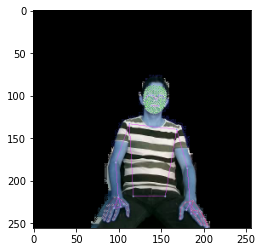

In [55]:
# create val dataset
ld_val = Turkish_Dataset(val_path, val_label)
print("shape of first array", ld_val[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_val[5][0][0].numpy()
img_np_arr -= img_np_arr.min() 
img_np_arr /= img_np_arr.max()
plt.imshow(img_np_arr.transpose(1, 2, 0))
plt.show()

In [18]:
bs_train = 4
bs_test = 4
bs_val = 4
train_loader = DataLoader(ld_train, batch_size = bs_train, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = bs_test, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

In [19]:
model = CNN_LSTM(u_len_label, 
                 latent_size=512, 
                 n_cnn_layers=6, 
                 n_rnn_layers=1, 
                 n_rnn_hidden_dim=512, 
                 cnn_bn=True, 
                 bidirectional=True, 
                 dropout_rate=0.8, 
                 attention=True)
summary(model, input_size=(4, 30, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_LSTM                                 [4, 226]                  --
├─CNN_Encoder: 1-1                       [120, 512]                --
│    └─Conv2d: 2-1                       [120, 64, 127, 127]       1,792
│    └─Sequential: 2-2                   [120, 256, 6, 6]          --
│    │    └─ConvBlock: 3-1               [120, 64, 61, 61]         74,112
│    │    └─ConvBlock: 3-2               [120, 128, 28, 28]        221,952
│    │    └─ConvBlock: 3-3               [120, 128, 24, 24]        295,680
│    │    └─ConvBlock: 3-4               [120, 256, 10, 10]        886,272
│    │    └─ConvBlock: 3-5               [120, 256, 6, 6]          1,181,184
│    └─ConvBlock: 2-3                    [120, 512, 1, 1]          --
│    │    └─Conv2d: 3-6                  [120, 512, 4, 4]          1,180,160
│    │    └─BatchNorm2d: 3-7             [120, 512, 4, 4]          1,024
│    │    └─ReLU: 3-8                    [120,

In [20]:
# hyperparams
no_of_epochs = 1000
optimizer_lr = 1e-5
save_dir = "saved_models/train_final_masked"

In [21]:
train(model, 
      train_loader, 
      val_loader, 
      no_of_epochs, 
      logger,
      writer,
      save_dir=save_dir, 
      save_checkpoint=True,
      device=device, 
      patience=10, 
      optimizer_lr=optimizer_lr, 
      use_scheduler=True)

######################Training Started######################
Epoch 1
100%|██████████| 7031/7031 [3:05:27<00:00,  1.58s/batch, accuracy=0, loss=4.54]      
Average Training Loss of Epoch 1: 5.251638 | Acc: 1.03%
100%|██████████| 1104/1104 [16:44<00:00,  1.10batch/s, accuracy=0, loss=6.98]   
Average Validation Loss of Epoch 1: 5.034524 | Acc: 2.06%
####################Epoch 1 Model Saved#####################
Epoch 2
100%|██████████| 7031/7031 [1:55:28<00:00,  1.01batch/s, accuracy=0, loss=4.01]   
Average Training Loss of Epoch 2: 4.332445 | Acc: 5.97%
100%|██████████| 1104/1104 [16:00<00:00,  1.15batch/s, accuracy=0, loss=6.53]   
Average Validation Loss of Epoch 2: 4.431714 | Acc: 9.22%
####################Epoch 2 Model Saved#####################
Epoch 3
100%|██████████| 7031/7031 [1:54:36<00:00,  1.02batch/s, accuracy=0, loss=3.28]   
Average Training Loss of Epoch 3: 3.611264 | Acc: 16.58%
100%|██████████| 1104/1104 [16:40<00:00,  1.10batch/s, accuracy=0, loss=3.29]   
Average Valid

Epoch     9: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 7031/7031 [1:58:15<00:00,  1.01s/batch, accuracy=0.667, loss=1.18]  
Average Training Loss of Epoch 10: 0.878426 | Acc: 82.85%
100%|██████████| 1104/1104 [17:36<00:00,  1.05batch/s, accuracy=0, loss=1.32]    
Average Validation Loss of Epoch 10: 3.543235 | Acc: 25.72%
####################Epoch 10 Model Saved####################
Epoch 11
100%|██████████| 7031/7031 [2:13:28<00:00,  1.14s/batch, accuracy=0.667, loss=1.08]  
Average Training Loss of Epoch 11: 0.805137 | Acc: 85.71%
100%|██████████| 1104/1104 [17:33<00:00,  1.05batch/s, accuracy=1, loss=0.526]   
Average Validation Loss of Epoch 11: 3.532911 | Acc: 26.42%
####################Epoch 11 Model Saved####################
Epoch 12
100%|██████████| 7031/7031 [2:12:12<00:00,  1.13s/batch, accuracy=1, loss=0.348]     
Average Training Loss of Epoch 12: 0.757922 | Acc: 87.24%
100%|██████████| 1104/1104 [19:13<00:00,  1.04s/batch, accuracy=1, loss=0.501]  
Average Validation Loss of Epoch 12: 3.608754 | Acc: 25.06%
###

Epoch    15: reducing learning rate of group 0 to 1.0000e-07.


100%|██████████| 7031/7031 [1:56:37<00:00,  1.00batch/s, accuracy=1, loss=0.389]     
Average Training Loss of Epoch 16: 0.605810 | Acc: 91.94%
100%|██████████| 1104/1104 [16:39<00:00,  1.10batch/s, accuracy=0, loss=2.18]   
Average Validation Loss of Epoch 16: 3.708137 | Acc: 24.63%
####################Epoch 16 Model Saved####################
Increment early stopper to 5 because val loss (3.7081371211055396) is greater than threshold (3.532910531197769)
Epoch 17
100%|██████████| 7031/7031 [1:56:26<00:00,  1.01batch/s, accuracy=1, loss=0.734]     
Average Training Loss of Epoch 17: 0.598665 | Acc: 92.14%
100%|██████████| 1104/1104 [16:27<00:00,  1.12batch/s, accuracy=0, loss=2.06]   
Average Validation Loss of Epoch 17: 3.690118 | Acc: 24.54%
####################Epoch 17 Model Saved####################
Increment early stopper to 6 because val loss (3.690117535005877) is greater than threshold (3.532910531197769)
Epoch 18
100%|██████████| 7031/7031 [2:25:22<00:00,  1.24s/batch, accuracy

Epoch    19: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 7031/7031 [2:05:38<00:00,  1.07s/batch, accuracy=1, loss=0.659]     
Average Training Loss of Epoch 20: 0.585876 | Acc: 92.63%
100%|██████████| 1104/1104 [22:14<00:00,  1.21s/batch, accuracy=0, loss=3.71]    
Average Validation Loss of Epoch 20: 3.714222 | Acc: 24.29%
####################Epoch 20 Model Saved####################
Increment early stopper to 9 because val loss (3.714221527772969) is greater than threshold (3.532910531197769)
Epoch 21
100%|██████████| 7031/7031 [3:05:11<00:00,  1.58s/batch, accuracy=0.667, loss=0.928]   
Average Training Loss of Epoch 21: 0.586502 | Acc: 92.40%
100%|██████████| 1104/1104 [52:49<00:00,  2.87s/batch, accuracy=0, loss=6.57]     
Average Validation Loss of Epoch 21: 3.737750 | Acc: 24.11%
####################Epoch 21 Model Saved####################
Increment early stopper to 10 because val loss (3.7377501164657483) is greater than threshold (3.532910531197769)
Model has overfit, early stopping...
#####################Training F

CNN_LSTM(
  (encoder): CNN_Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layers): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (a_fn): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(128, 